In [8]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

sys.path.append('../src')

from clustering import *

In [9]:
df = pd.read_csv('../Data/Processed/nse_features.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Stock_code         57 non-null     object 
 1   Sector             57 non-null     object 
 2   Name               57 non-null     object 
 3   trading_days       57 non-null     int64  
 4   total_days         57 non-null     int64  
 5   trading_frequency  57 non-null     float64
 6   mean_return        57 non-null     float64
 7   std_return         57 non-null     float64
 8   volatility_7d      57 non-null     float64
 9   volatility_30d     57 non-null     float64
 10  max_drawdown       57 non-null     float64
 11  avg_volume         57 non-null     float64
 12  zero_volume_ratio  57 non-null     float64
 13  momentum_30d       57 non-null     float64
 14  current_price      57 non-null     float64
dtypes: float64(10), int64(2), object(3)
memory usage: 6.8+ KB


In [10]:
feature_cols = [
    'volatility_7d', 'volatility_30d', 'max_drawdown',
    'trading_frequency', 'zero_volume_ratio', 'avg_volume',
    'mean_return', 'std_return', 'momentum_30d'
]

cluster_metrics = find_optimal_clusters(df, feature_cols)
print(cluster_metrics)

   n_clusters     inertia  silhouette
0           2  378.393621    0.286709
1           3  264.477506    0.319076
2           4  211.043201    0.328970
3           5  163.084824    0.333518
4           6  134.988009    0.245393
5           7  113.978977    0.255123
6           8   97.151793    0.263690


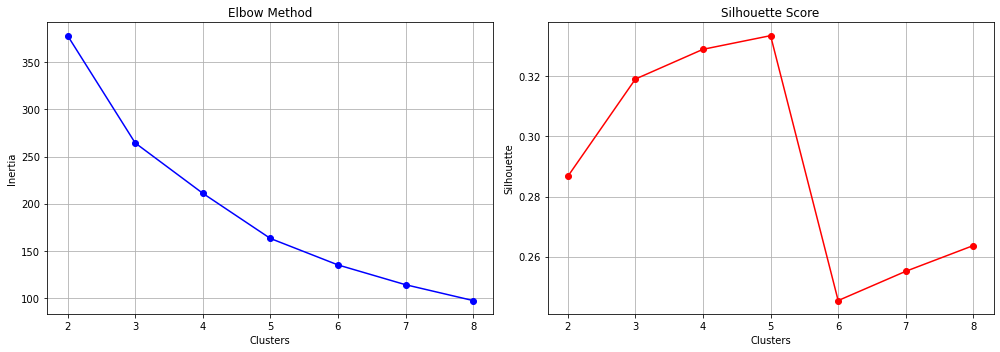

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(cluster_metrics['n_clusters'], cluster_metrics['inertia'], 'bo-')
ax1.set_title('Elbow Method')
ax1.set_xlabel('Clusters')
ax1.set_ylabel('Inertia')
ax1.grid(True)

ax2.plot(cluster_metrics['n_clusters'], cluster_metrics['silhouette'], 'ro-')
ax2.set_title('Silhouette Score')
ax2.set_xlabel('Clusters')
ax2.set_ylabel('Silhouette')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [12]:
clusterer = StockClusterer(n_clusters=4, random_state=42)
df_clustered = clusterer.fit_predict(df)

print(f"\nCluster counts:")
print(df_clustered['Cluster'].value_counts().sort_index())

 Clustering complete. Silhouette: 0.329

Cluster counts:
0    28
1    25
2     3
3     1
Name: Cluster, dtype: int64


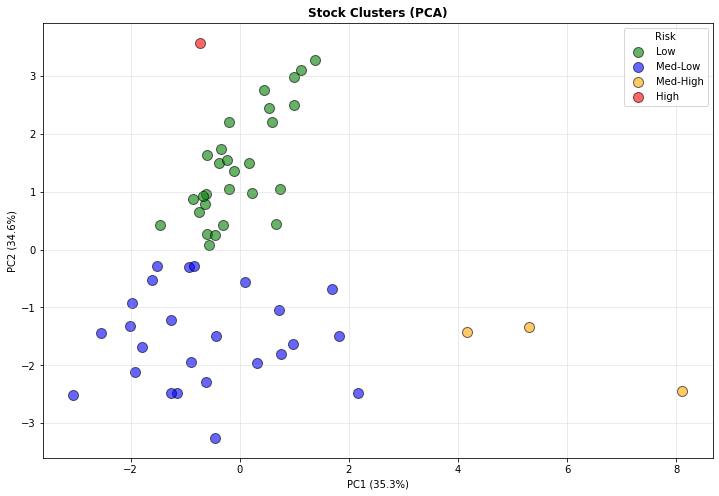

In [13]:
X = df_clustered[feature_cols].fillna(0)
X_scaled = clusterer.scaler.transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
colors = ['green', 'blue', 'orange', 'red']
labels = ['Low', 'Med-Low', 'Med-High', 'High']

for cluster, color, label in zip(range(4), colors, labels):
    mask = df_clustered['Cluster'] == cluster
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                c=color, label=label, alpha=0.6, s=100, edgecolors='black')

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.title('Stock Clusters (PCA)', fontweight='bold')
plt.legend(title='Risk')
plt.grid(True, alpha=0.3)
plt.show()

In [14]:
df_clustered.to_csv('../Data/Processed/nse_clustered.csv', index=False)